In [1]:
import base64
from embed_anything import EmbedData, ColpaliModel
import numpy as np
from tabulate import tabulate
from pathlib import Path
from PIL import Image
import io


model: ColpaliModel = ColpaliModel.from_pretrained("vidore/colpali-v1.2-merged", None)

def process_pdf(files, model:ColpaliModel):
    file_embed_data: list[EmbedData] = []
    for file in files:
        try:
            embedding: list[EmbedData] = model.embed_file(str(file), batch_size=1)
            file_embed_data.extend(embedding)   
        except Exception as e:
            print(f"Error embedding file {file}: {e}")

    return file_embed_data



In [2]:
def process_query(query, model):    
    query_embedding = model.embed_query(query)
    query_embeddings = np.array([e.embedding for e in query_embedding])
    return query_embeddings

def score(query_embeddings, file_embed_data):
    file_embeddings = np.array([e.embedding for e in file_embed_data])
    scores = np.einsum("bnd,csd->bcns", query_embeddings, file_embeddings).max(axis=3).sum(axis=2).squeeze()

    # Get top pages
    top_pages = np.argsort(scores)[::-1][:3]

    # Extract file names and page numbers
    table = [
        [file_embed_data[page].metadata["file_path"].split("/")[-1], file_embed_data[page].metadata["page_number"]]
        for page in top_pages
    ]

    # Print the results in a table
    print(tabulate(table, headers=["File Name", "Page Number"], tablefmt="grid"))
    results_str = tabulate(table, headers=["File Name", "Page Number"], tablefmt="grid")

    images = [file_embed_data[page].metadata["image"] for page in top_pages]
    images = [Image.open(io.BytesIO(base64.b64decode(image))) for image in images]
    return images, results_str


+--------------------------------+---------------+
| File Name                      |   Page Number |
+================================+===============+
| ..\..\test_files\attention.pdf |            14 |
+--------------------------------+---------------+
| ..\..\test_files\attention.pdf |            15 |
+--------------------------------+---------------+
| ..\..\test_files\linear.pdf    |             3 |
+--------------------------------+---------------+


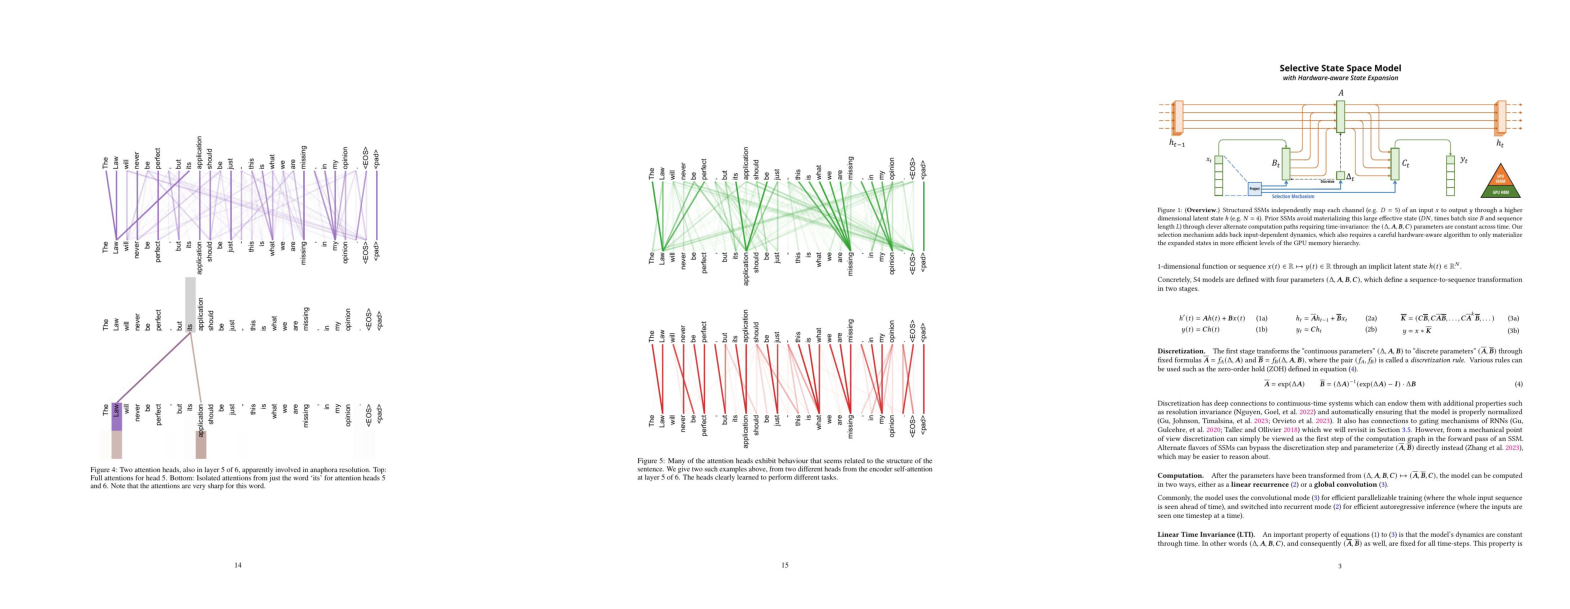

In [3]:
# Get all PDF files in the directory
directory = Path("../../test_files")
files = list(directory.glob("*.pdf"))
file_embed_data = process_pdf(files, model)
query = "What is the first page of the pdf"
query_embeddings = process_query(query, model)
images, results_str = score(query_embeddings, file_embed_data)

import matplotlib.pyplot as plt
# show the images side by side using subplots
fig, axs = plt.subplots(1, len(images), figsize=(20, 15))
for i, image in enumerate(images):
    axs[i].imshow(image)
    axs[i].axis('off')
plt.show();


In [4]:
def process_pdf_on_upload(files):
    global embedded_file_data
    # Embed the uploaded PDF files
    embedded_file_data = process_pdf(files, model)
    return f"Processed {len(files)} PDFs"

In [5]:
import gradio as gr

# Gradio app interface
def gradio_app(query):
    global embedded_file_data
    if embedded_file_data is None:
        return [], "No PDFs have been uploaded or processed."
    
    # Process the query and return results
    query_embeddings = process_query(query, model)
    images, results_str = score(query_embeddings, embedded_file_data)
    
    return images, results_str
# Gradio Interface definition
with gr.Blocks() as demo:
    gr.Markdown("# PDF Search and Embedding App")
    
    with gr.Column():
        pdf_upload = gr.Files(label="Upload PDFs", file_types=[".pdf"])
        upload_status = gr.Textbox(label="Upload Status", interactive=False)
        query_input = gr.Textbox(label="Query")
        submit_btn = gr.Button("Submit")
    
    with gr.Row():
        gallery_output = gr.Gallery(label="Top Results Images")
        results_output = gr.Textbox(label="Results", interactive=False)
    
    # Embed PDFs when files are uploaded
    pdf_upload.upload(process_pdf_on_upload, inputs=pdf_upload, outputs=upload_status)
    
    # Handle the query when submit button is clicked
    submit_btn.click(gradio_app, inputs=[query_input], outputs=[gallery_output, results_output])

demo.launch()

c:\Users\sonam\anaconda3\envs\computervision\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


+----------------------------------------------------------------------------------------------------------------------+---------------+
| File Name                                                                                                            |   Page Number |
+======================================================================================================================+===============+
| C:\Users\sonam\AppData\Local\Temp\gradio\be0b0ad27ad22af2439ec6eb07b5c95d51129d1a35f9d6a5dc34483e41c86235\linear.pdf |             6 |
+----------------------------------------------------------------------------------------------------------------------+---------------+
| C:\Users\sonam\AppData\Local\Temp\gradio\be0b0ad27ad22af2439ec6eb07b5c95d51129d1a35f9d6a5dc34483e41c86235\linear.pdf |            34 |
+----------------------------------------------------------------------------------------------------------------------+---------------+
| C:\Users\sonam\AppData\Local\Temp\gradi